In [1]:
import os
import json
import yaml
import pickle

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

# Data

## Post test

In [3]:
with open('//ic1files.epfl.ch/D-VET/Projects/ChemLab/04_Processing/Processing/Data/PostTest/post_test.pkl', 'rb') as fp:
    post_test = pickle.load(fp)
    ranks = pd.DataFrame()
    ranks['lid'] = post_test[0, 'username']
    ranks['gender'] = post_test[0, 'gender']
    ranks['field'] = post_test[0, 'field']
    ranks['year'] = post_test[0, 'year']
    ranks['ranks'] = post_test[6, 'ranks']

    ranks = ranks[ranks['ranks'].notna()]
    ranks['permutation'] = ranks['ranks'].apply(lambda x: ''.join([str(r) for r in x]))

# ranks = ranks[ranks['year'] != '3rd']
ranks = ranks.sort_values(['permutation', 'year', 'gender'])

In [3]:
ranks.head()

,lid,gender,field,year,ranks,permutation
239,bw4svfmn,1,Chemistry,1st,"[0, 1, 2, 3]",0123
272,v5gwycag,1,Pharma Chemistry,1st,"[0, 1, 2, 3]",0123
304,6h5vmwys,1,Chemistry,1st,"[0, 1, 2, 3]",0123
380,r2q9q35x,1,Chemistry,1st,"[0, 1, 2, 3]",0123
23,4vtjgtja,1,"Chemistry, Textiles",2nd,"[0, 1, 2, 3]",0123


## Maps

In [4]:
with open('../../data/experiment_keys/permutation_maps/colour_binary.yaml') as fp:
    col_bin = yaml.load(fp, Loader=yaml.FullLoader)
    
with open('../../data/experiment_keys/permutation_maps/concentration_binary.yaml') as fp:
    con_bin = yaml.load(fp, Loader=yaml.FullLoader)
    
with open('../../data/experiment_keys/permutation_maps/width_binary.yaml') as fp:
    wid_bin = yaml.load(fp, Loader=yaml.FullLoader)
    
with open('../../data/experiment_keys/permutation_maps/colour_ternary.yaml') as fp:
    col_tri = yaml.load(fp, Loader=yaml.FullLoader)
    
with open('../../data/experiment_keys/permutation_maps/concentration_ternary.yaml') as fp:
    con_tri = yaml.load(fp, Loader=yaml.FullLoader)
    
with open('../../data/experiment_keys/permutation_maps/width_ternary.yaml') as fp:
    wid_tri = yaml.load(fp, Loader=yaml.FullLoader)

In [5]:
def get_labels(x:str, map_label:dict) -> str:
    lab = map_label['map'][x]
    if lab == 'no_width':
        return 'width_no'
    return lab

In [6]:
ranks['colbin'] = ranks['permutation'].apply(lambda x: get_labels(x, col_bin))
ranks['conbin'] = ranks['permutation'].apply(lambda x: get_labels(x, con_bin))
ranks['widbin'] = ranks['permutation'].apply(lambda x: get_labels(x, wid_bin))
# ranks['coltri'] = ranks['permutation'].apply(lambda x: get_labels(x, col_tri))
ranks['contri'] = ranks['permutation'].apply(lambda x: get_labels(x, con_tri))
ranks['widtri'] = ranks['permutation'].apply(lambda x: get_labels(x, wid_tri))

In [7]:
def get_trivector(row: np.array) -> str:
    vector = ''
    if row['colbin'] == 'colour':
        vector += '1'
    else:
        vector += '0'
    
    if row['conbin'] == 'concentration':
        vector += '1'
    else:
        vector += '0'
        
    if row['widbin'] == 'width':
        vector += '1'
    else:
        vector += '0'
    
    return vector
        

In [8]:
ranks['vector_label'] = ranks.apply(lambda x: get_trivector(x), axis=1)

In [9]:
ranks[['colbin', 'conbin', 'widbin', 'vector_label']].drop_duplicates()

,colbin,conbin,widbin,vector_label
239,no_col,no_conc,width_no,000
69,colour,no_conc,width_no,100
70,colour,concentration,width_no,110
62,colour,no_conc,width,101
336,colour,concentration,width,111
170,no_col,no_conc,width,001
166,no_col,concentration,width_no,010
58,no_col,concentration,width,011


In [10]:
def get_colour() -> str:
    random_palette = [
            'maroon', 'orangered', 'saddlebrown', 'goldenrod', 'olive', 'yellowgreen', 'forestgreen', 'teal', 'lightseagreen', 'paleturquoise', 'darkturquoise', 'cadetblue', 'deepskyblue', 'lightskyblue', 'steelblue', 'dodgerblue', 'cornflowerblue', 'royalblue', 'slateblue', 'mediumorchid', 'plum', 'orchid', 'deeppink'
    ]
    return random_palette[np.random.randint(len(random_palette))]

palette = {
    'colour': '#F5F9E9',
    'inv_col': '#A4036F',
    'no_col': '#C2C1A5',
    'width': '#C2C1A5',
    'inv_width': '#62B6CB',
    'no_width': '#CAE9FF',
    'width_no': '#CAE9FF',
    'concentration': '#F0F0C9',
    'inv_conc': '#D74E09',
    'no_conc': '#F2BB05',
    '1st': '#D4E6B5',
    '2nd': '#AFC97E',
    '3rd': '#A2A3BB',
    1: '#BFD1E5',
    2: '#EBF5EE',
    3: '#D8BFAA',
    4: '#EB9486',
    'Chemistry, Textiles': '#EEEBD3',
    'Chemistry': '#A98743',
    'Biology': '#F7C548',
    'Pharma Chemistry': '#80A4ED',
    '000': '#A49966',
    '100': '#C7C7A6',
    '010': '#EAFFDA',
    '001': '#EF476F',
    '110': '#5D3A00',
    '101': '#B279A7',
    '011': '#D387AB',
    '111': '#E899DC',
    '0': '#92B4F4',
    '1': '#CFDEE7',
    '2': '#F46197',
    '3': '#AF7595'
}
for p in ranks['permutation'].unique():
    palette[p] = get_colour()

In [11]:
def get_percentage(df, grouping:list, stratification: str):
    d = df[['year', 'lid', 'permutation', 'gender', 'field', 'no_strat', 'colbin', 'conbin', 'widbin', 'contri', 'widtri', 'vector_label', 'nconcepts']].groupby(grouping).nunique()['lid'].reset_index()
    
    strat = df[[stratification, 'lid']]
    strat = strat.groupby(stratification).nunique()['lid'].reset_index()
    strat.columns = [stratification, 'total_counts']
    
    new = d.merge(strat, how='inner', on=stratification)
    new['height'] = new['lid'] / new['total_counts']
    return new

ranks['no_strat'] = 0

# Data EDA

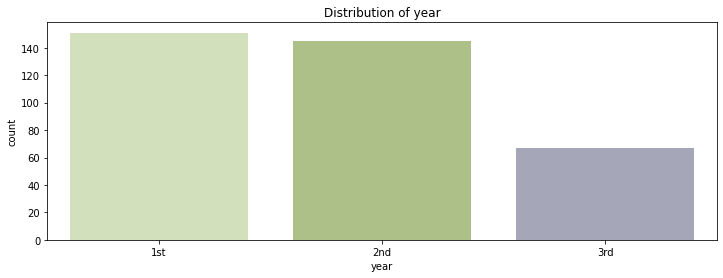

In [12]:
plt.figure(figsize=(12, 4))
sns.countplot(x=ranks['year'], palette=palette)
plt.title('Distribution of year')
plt.show()

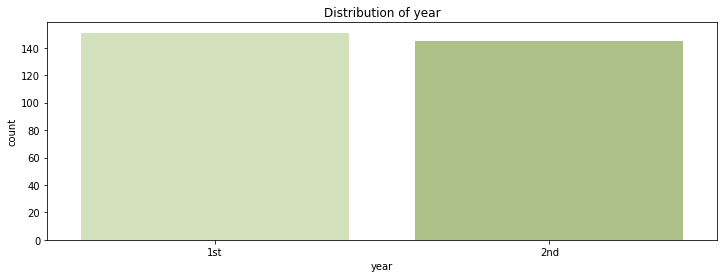

In [13]:
tempranks = ranks[ranks['year'] != '3rd']
plt.figure(figsize=(12, 4))
sns.countplot(x=tempranks['year'], palette=palette)
plt.title('Distribution of year')
plt.show()

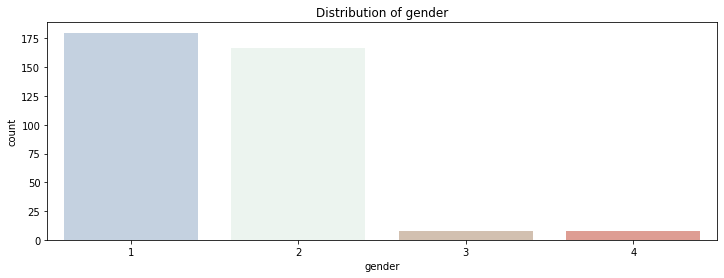

In [14]:
plt.figure(figsize=(12, 4))
sns.countplot(x=ranks['gender'], palette=palette)
plt.title('Distribution of gender')
plt.show()

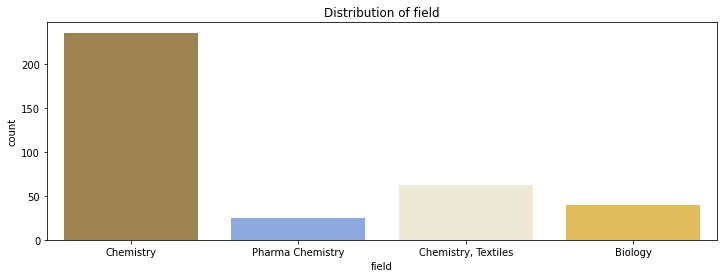

In [15]:
plt.figure(figsize=(12, 4))
sns.countplot(x=ranks['field'], palette=palette)
plt.title('Distribution of field')
plt.show()

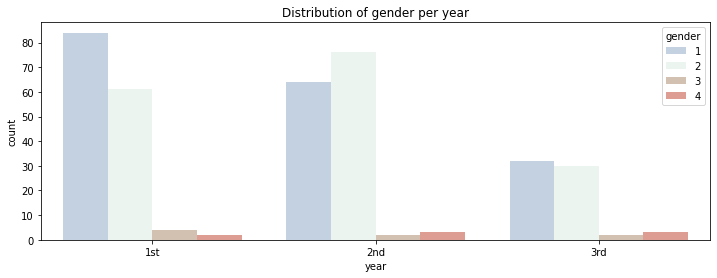

In [16]:
plt.figure(figsize=(12, 4))
sns.countplot(x='year', hue='gender', data=ranks, palette=palette)
plt.title('Distribution of gender per year')
plt.show()

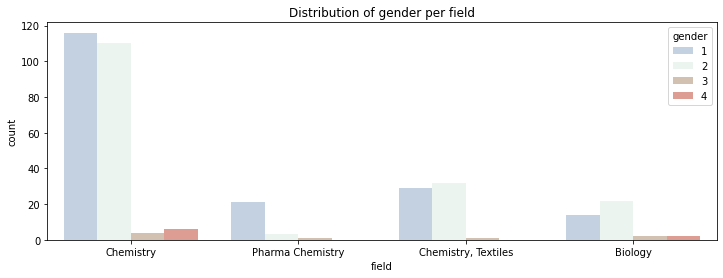

In [17]:
plt.figure(figsize=(12, 4))
sns.countplot(x='field', hue='gender', data=ranks, palette=palette)
plt.title('Distribution of gender per field')
plt.show()

# Permutation EDA

In [18]:
ranks['no_strat'] = 0

In [19]:
ranks['nconcepts'] = ranks['vector_label'].apply(lambda x: sum([int(label) for label in x])).astype(str)

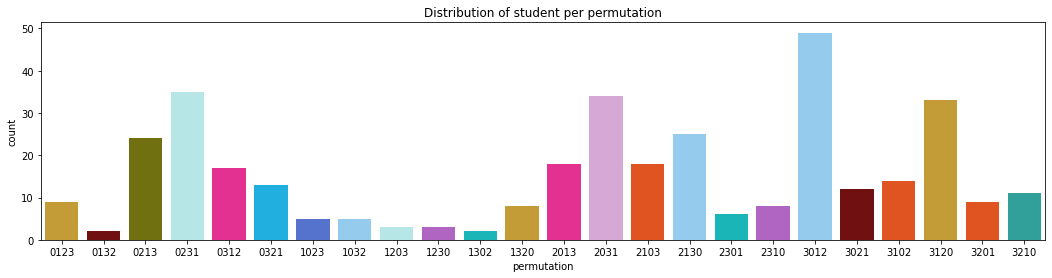

In [20]:
plt.figure(figsize=(18, 4))
sns.countplot(x='permutation', data=ranks, palette=palette)
plt.title('Distribution of student per permutation')
plt.show()

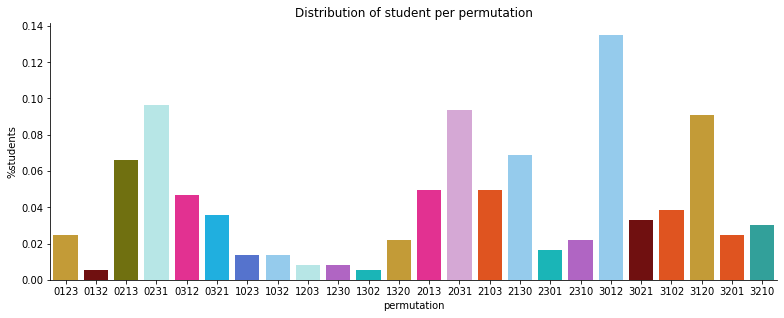

In [21]:
data = get_percentage(ranks, ['permutation', 'no_strat'], 'no_strat')
s = sns.catplot(x='permutation', y='height', kind='bar', data=data, palette=palette)
s.fig.set_size_inches(12, 4)
plt.title('Distribution of student per permutation')
plt.ylabel('%students')
plt.show()

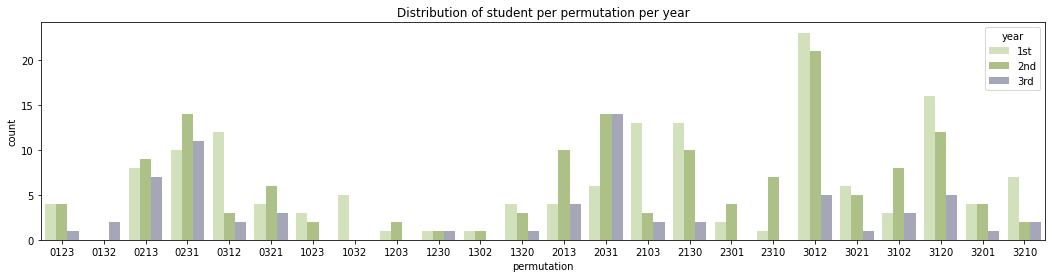

In [22]:
plt.figure(figsize=(18, 4))
sns.countplot(x='permutation', hue='year', data=ranks, palette=palette)
plt.title('Distribution of student per permutation per year')
plt.show()

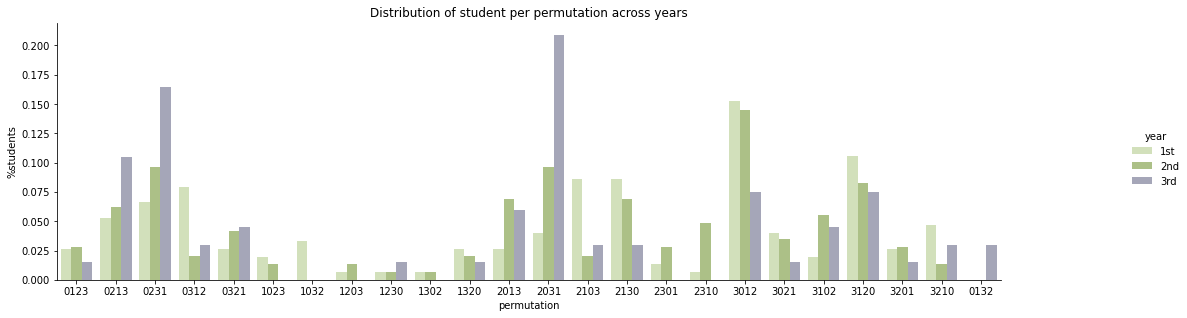

In [23]:
data = get_percentage(ranks, ['permutation', 'year'], 'year')
s = sns.catplot(x='permutation', y='height', hue='year', kind='bar', data=data, palette=palette)
s.fig.set_size_inches(18, 4)
plt.title('Distribution of student per permutation across years')
plt.ylabel('%students')
plt.show()

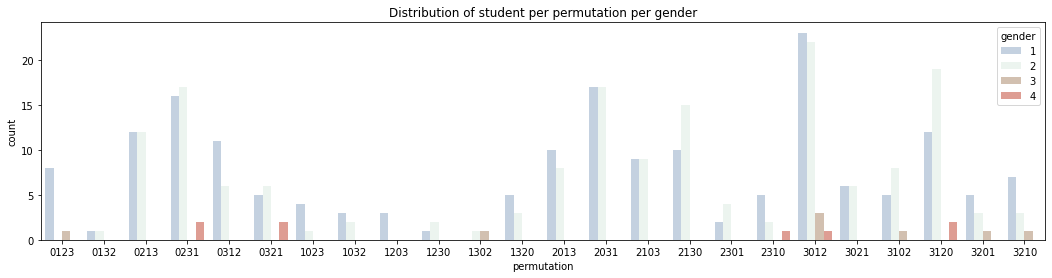

In [24]:
plt.figure(figsize=(18, 4))
sns.countplot(x='permutation', hue='gender', data=ranks, palette=palette)
plt.title('Distribution of student per permutation per gender')
plt.show()

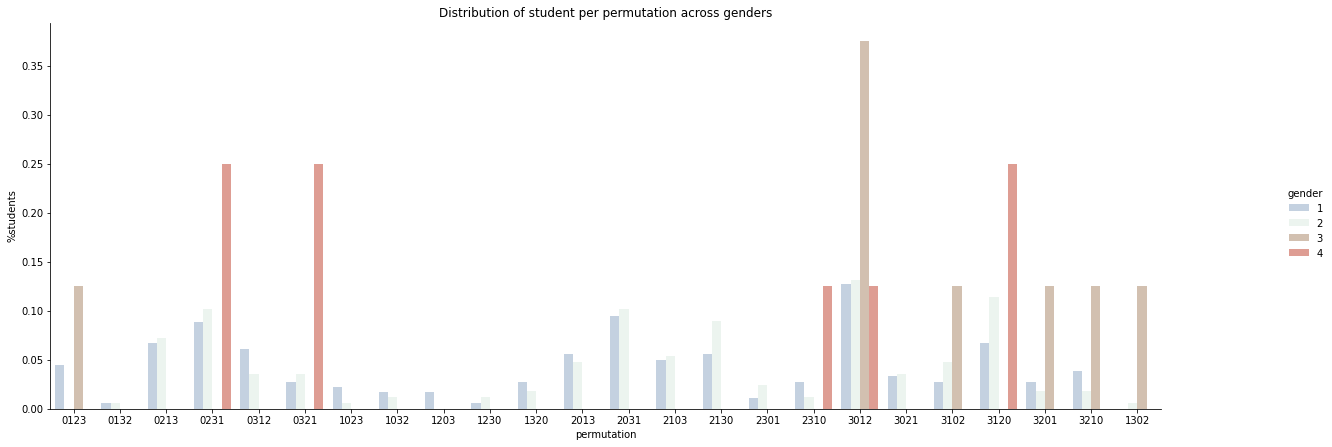

In [25]:
data = get_percentage(ranks, ['permutation', 'gender'], 'gender')
s = sns.catplot(x='permutation', y='height', hue='gender', kind='bar', data=data, palette=palette)
s.fig.set_size_inches(20, 6)
plt.title('Distribution of student per permutation across genders')
plt.ylabel('%students')
plt.show()

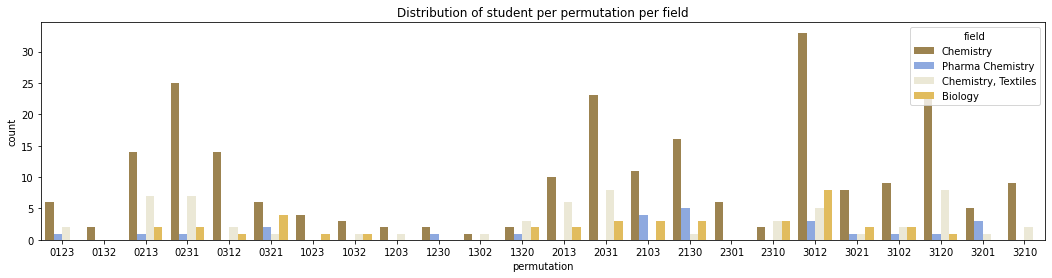

In [26]:
plt.figure(figsize=(18, 4))
sns.countplot(x='permutation', hue='field', data=ranks, palette=palette)
plt.title('Distribution of student per permutation per field')
plt.show()

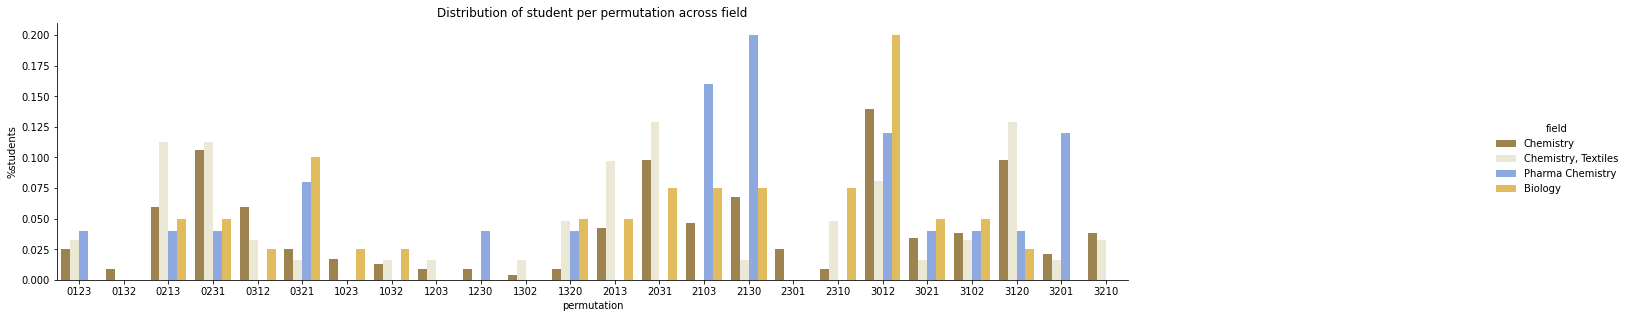

In [27]:
data = get_percentage(ranks, ['permutation', 'field'], 'field')
s = sns.catplot(x='permutation', y='height', hue='field', kind='bar', data=data, palette=palette)
s.fig.set_size_inches(25, 4)
plt.title('Distribution of student per permutation across field')
plt.ylabel('%students')
plt.show()

# Rankings EDA

## Colour

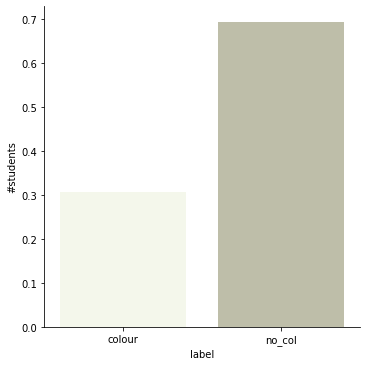

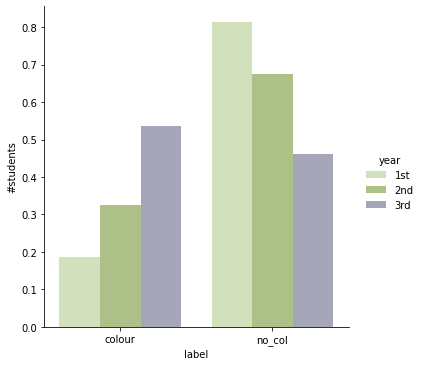

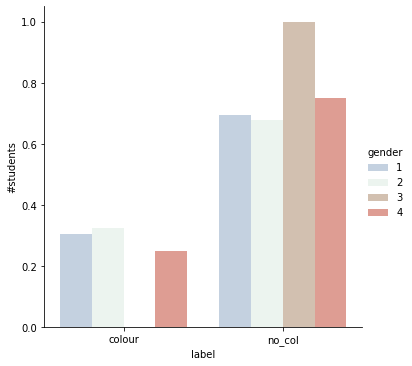

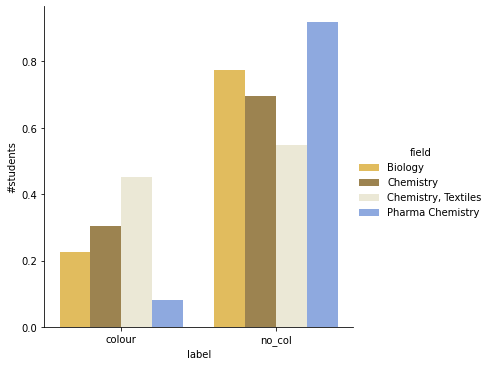

In [28]:
ranks = ranks.sort_values(['year', 'colbin'], ascending=True)
# plt.figure(figsize=(24, 4))

data = get_percentage(ranks, ['colbin', 'no_strat'], 'no_strat')
s = sns.catplot(x='colbin', y='height', kind='bar', data=data, palette=palette, margin_titles=True)
plt.ylabel('#students')
plt.xlabel('label')
plt.show()

data = get_percentage(ranks, ['colbin', 'year'], 'year')
s = sns.catplot(x='colbin', y='height', hue='year', kind='bar', data=data, palette=palette, margin_titles=True)
plt.ylabel('#students')
plt.xlabel('label')
plt.show()

data = get_percentage(ranks, ['colbin', 'gender'], 'gender')
s = sns.catplot(x='colbin', y='height', hue='gender', kind='bar', data=data, palette=palette)
plt.ylabel('#students')
plt.xlabel('label')
plt.show()

data = get_percentage(ranks, ['colbin', 'field'], 'field')
s = sns.catplot(x='colbin', y='height', hue='field', kind='bar', data=data, palette=palette)
plt.ylabel('#students')
plt.xlabel('label')
plt.show()

In [29]:
len(ranks)

363

## Concentration

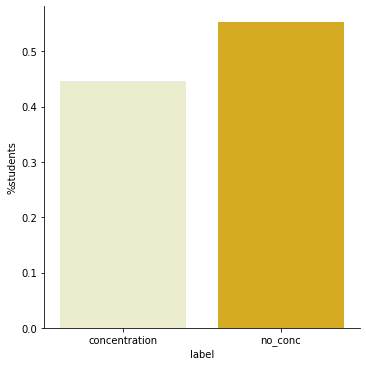

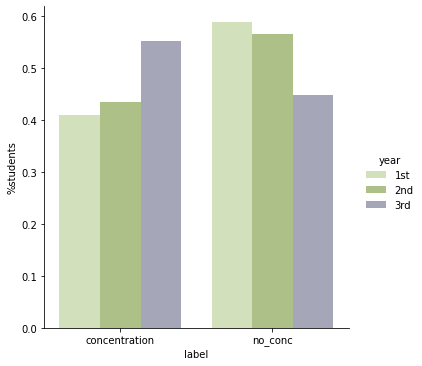

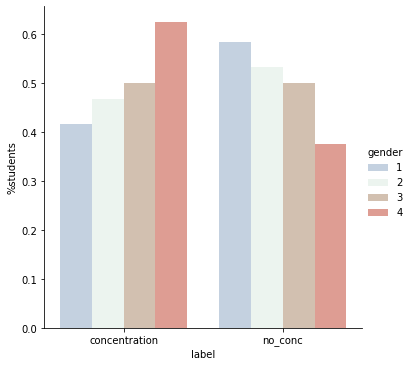

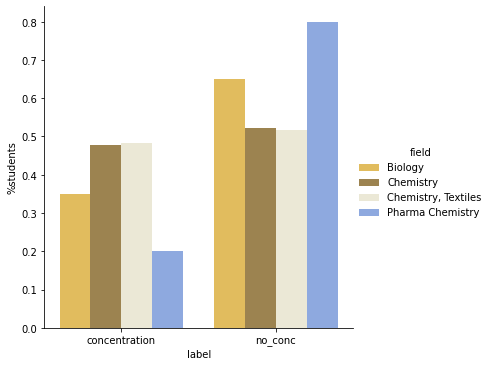

In [30]:
ranks = ranks.sort_values(['year', 'conbin'], ascending=True)
# plt.figure(figsize=(24, 4))

data = get_percentage(ranks, ['conbin', 'no_strat'], 'no_strat')
s = sns.catplot(x='conbin', y='height', kind='bar', data=data, palette=palette, margin_titles=True)
plt.ylabel('%students')
plt.xlabel('label')
plt.show()

data = get_percentage(ranks, ['conbin', 'year'], 'year')
s = sns.catplot(x='conbin', y='height', hue='year', kind='bar', data=data, palette=palette, margin_titles=True)
plt.ylabel('%students')
plt.xlabel('label')
plt.show()

data = get_percentage(ranks, ['conbin', 'gender'], 'gender')
s = sns.catplot(x='conbin', y='height', hue='gender', kind='bar', data=data, palette=palette)
plt.ylabel('%students')
plt.xlabel('label')
plt.show()

data = get_percentage(ranks, ['conbin', 'field'], 'field')
s = sns.catplot(x='conbin', y='height', hue='field', kind='bar', data=data, palette=palette)
plt.ylabel('%students')
plt.xlabel('label')
plt.show()

## Width

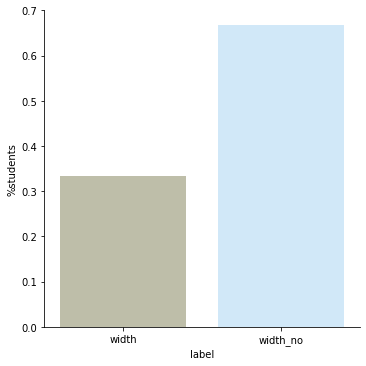

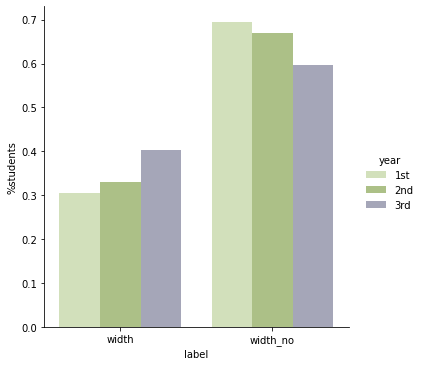

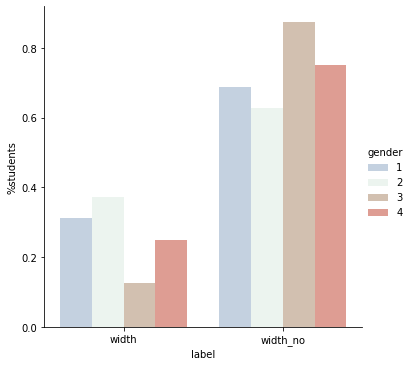

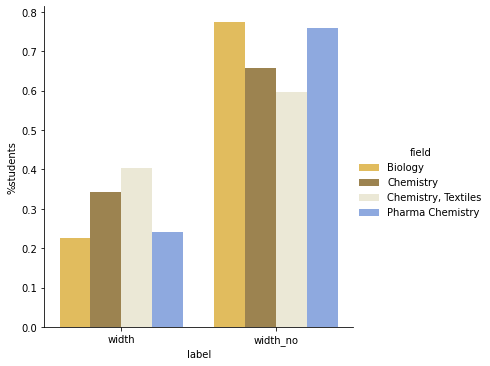

In [31]:
ranks = ranks.sort_values(['year', 'widbin'], ascending=True)
# plt.figure(figsize=(24, 4))

data = get_percentage(ranks, ['widbin', 'no_strat'], 'no_strat')
s = sns.catplot(x='widbin', y='height', kind='bar', data=data, palette=palette, margin_titles=True)
plt.ylabel('%students')
plt.xlabel('label')
plt.show()

data = get_percentage(ranks, ['widbin', 'year'], 'year')
s = sns.catplot(x='widbin', y='height', hue='year', kind='bar', data=data, palette=palette, margin_titles=True)
plt.ylabel('%students')
plt.xlabel('label')
plt.show()

data = get_percentage(ranks, ['widbin', 'gender'], 'gender')
s = sns.catplot(x='widbin', y='height', hue='gender', kind='bar', data=data, palette=palette)
plt.ylabel('%students')
plt.xlabel('label')
plt.show()

data = get_percentage(ranks, ['widbin', 'field'], 'field')
s = sns.catplot(x='widbin', y='height', hue='field', kind='bar', data=data, palette=palette)
plt.ylabel('%students')
plt.xlabel('label')
plt.show()

# Ternary rankings

## colour

In [20]:
ranks = ranks.sort_values(['year', 'coltri'], ascending=True)
# plt.figure(figsize=(24, 4))

data = get_percentage(ranks, ['coltri', 'no_strat'], 'no_strat')
s = sns.catplot(x='coltri', y='height', kind='bar', data=data, palette=palette, margin_titles=True)
plt.ylabel('%students')
plt.xlabel('label')
plt.show()

data = get_percentage(ranks, ['coltri', 'year'], 'year')
s = sns.catplot(x='coltri', y='height', hue='year', kind='bar', data=data, palette=palette, margin_titles=True)
plt.ylabel('%students')
plt.xlabel('label')
plt.show()

data = get_percentage(ranks, ['coltri', 'gender'], 'gender')
s = sns.catplot(x='coltri', y='height', hue='gender', kind='bar', data=data, palette=palette)
plt.ylabel('%students')
plt.xlabel('label')
plt.show()

data = get_percentage(ranks, ['coltri', 'field'], 'field')
s = sns.catplot(x='coltri', y='height', hue='field', kind='bar', data=data, palette=palette)
plt.ylabel('%students')
plt.xlabel('label')
plt.show()

KeyError: 'coltri'

## concentration

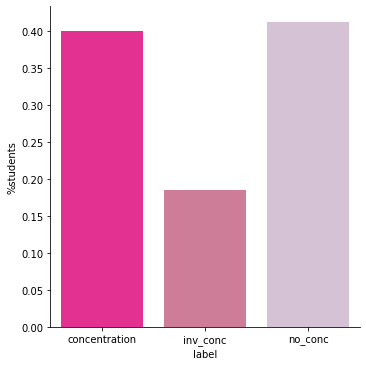

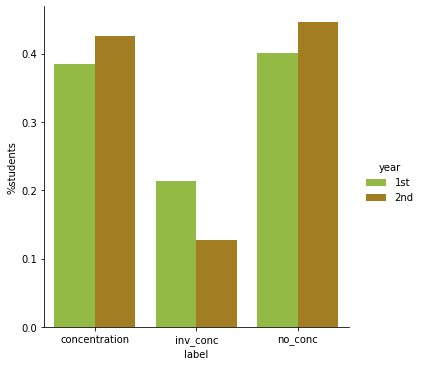

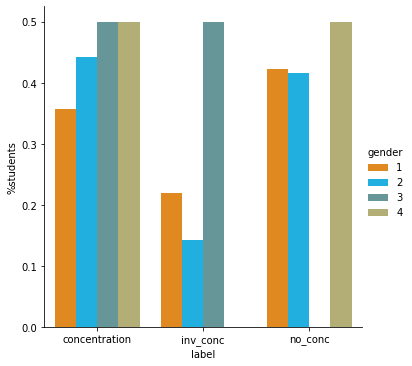

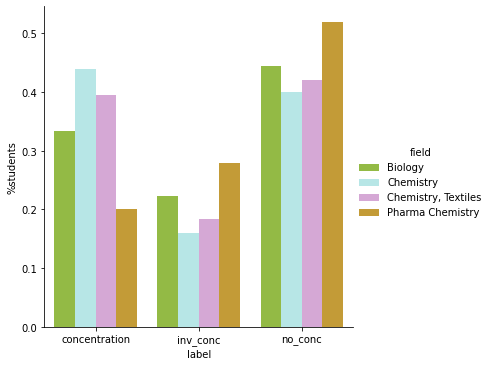

In [148]:
ranks = ranks.sort_values(['year', 'contri'], ascending=True)
# plt.figure(figsize=(24, 4))

data = get_percentage(ranks, ['contri', 'no_strat'], 'no_strat')
s = sns.catplot(x='contri', y='height', kind='bar', data=data, palette=palette, margin_titles=True)
plt.ylabel('%students')
plt.xlabel('label')
plt.show()

data = get_percentage(ranks, ['contri', 'year'], 'year')
s = sns.catplot(x='contri', y='height', hue='year', kind='bar', data=data, palette=palette, margin_titles=True)
plt.ylabel('%students')
plt.xlabel('label')
plt.show()

data = get_percentage(ranks, ['contri', 'gender'], 'gender')
s = sns.catplot(x='contri', y='height', hue='gender', kind='bar', data=data, palette=palette)
plt.ylabel('%students')
plt.xlabel('label')
plt.show()

data = get_percentage(ranks, ['contri', 'field'], 'field')
s = sns.catplot(x='contri', y='height', hue='field', kind='bar', data=data, palette=palette)
plt.ylabel('%students')
plt.xlabel('label')
plt.show()

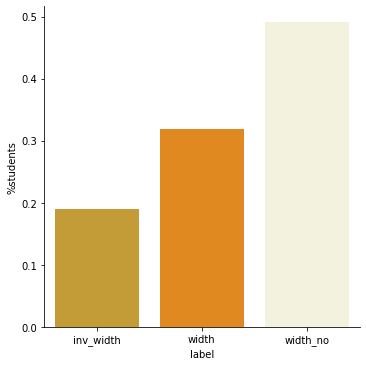

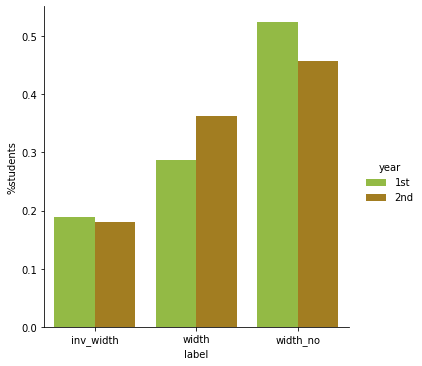

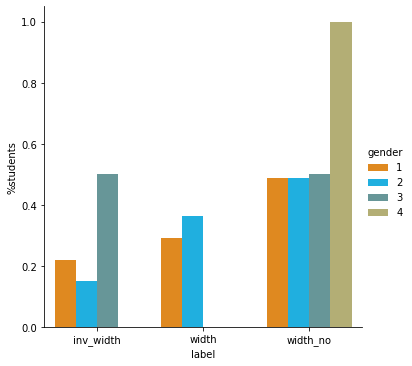

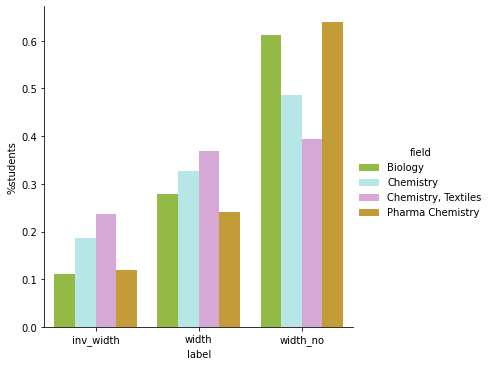

In [149]:
ranks = ranks.sort_values(['year', 'widtri'], ascending=True)
# plt.figure(figsize=(24, 4))

data = get_percentage(ranks, ['widtri', 'no_strat'], 'no_strat')
s = sns.catplot(x='widtri', y='height', kind='bar', data=data, palette=palette, margin_titles=True)
plt.ylabel('%students')
plt.xlabel('label')
plt.show()

data = get_percentage(ranks, ['widtri', 'year'], 'year')
s = sns.catplot(x='widtri', y='height', hue='year', kind='bar', data=data, palette=palette, margin_titles=True)
plt.ylabel('%students')
plt.xlabel('label')
plt.show()

data = get_percentage(ranks, ['widtri', 'gender'], 'gender')
s = sns.catplot(x='widtri', y='height', hue='gender', kind='bar', data=data, palette=palette)
plt.ylabel('%students')
plt.xlabel('label')
plt.show()

data = get_percentage(ranks, ['widtri', 'field'], 'field')
s = sns.catplot(x='widtri', y='height', hue='field', kind='bar', data=data, palette=palette)
plt.ylabel('%students')
plt.xlabel('label')
plt.show()

# Label EDA

In [32]:
order = [
    '000',
    '100', '010', '001',
    '110', '101', '011',
    '111'
]

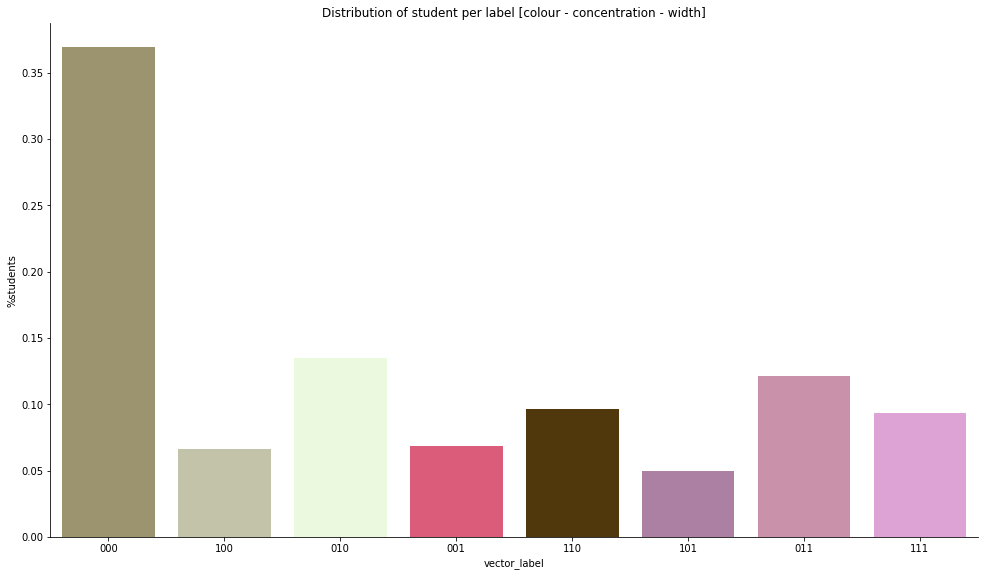

In [33]:
data = get_percentage(ranks, ['vector_label', 'no_strat'], 'no_strat')
s = sns.catplot(x='vector_label', y='height', kind='bar', order=order, data=data, palette=palette)
s.fig.set_size_inches(15, 8)
plt.title('Distribution of student per label [colour - concentration - width]')
plt.ylabel('%students')
plt.savefig('../../reports/LAK/figures/vector label distribution.svg', format='svg')
plt.show()

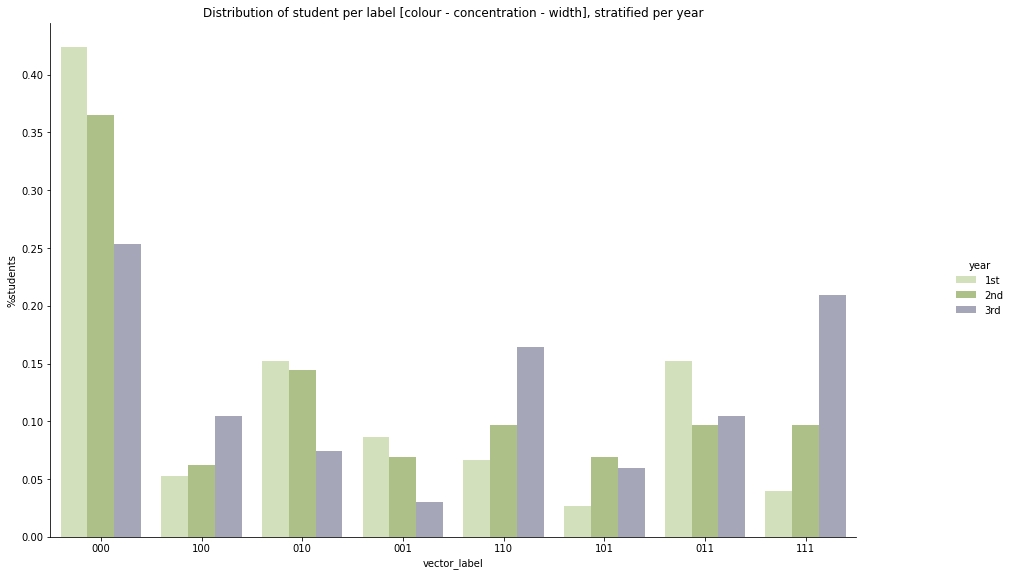

In [34]:
data = get_percentage(ranks, ['vector_label', 'year'], 'year')
s = sns.catplot(x='vector_label', y='height', hue='year', kind='bar', order=order, data=data, palette=palette)
s.fig.set_size_inches(15, 8)
plt.title('Distribution of student per label [colour - concentration - width], stratified per year')
plt.ylabel('%students')
plt.savefig('../../reports/LAK/figures/vector label distribution - year.svg', format='svg')
plt.show()

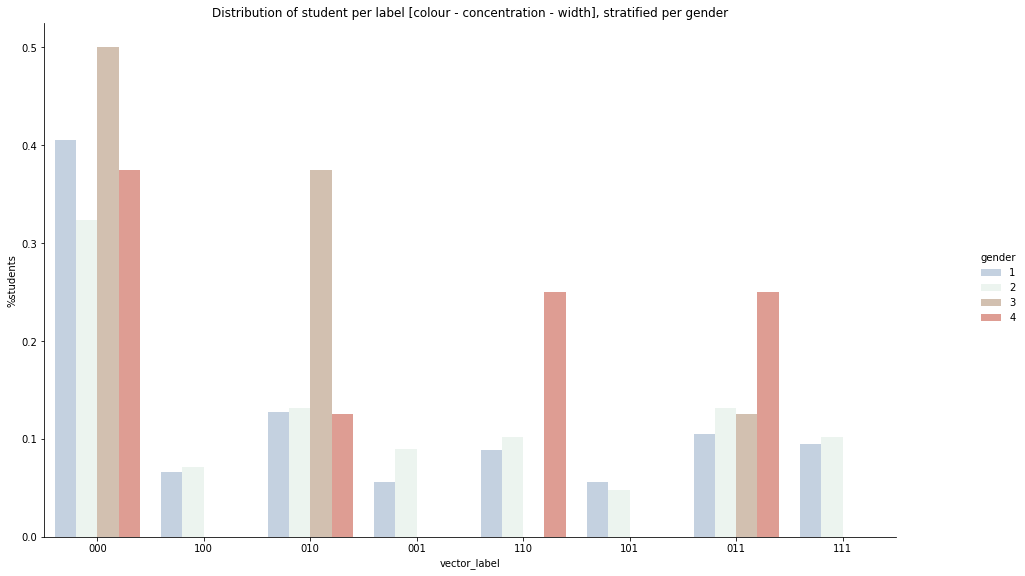

In [35]:
data = get_percentage(ranks, ['vector_label', 'gender'], 'gender')
s = sns.catplot(x='vector_label', y='height', hue='gender', kind='bar', order=order, data=data, palette=palette)
s.fig.set_size_inches(15, 8)
plt.title('Distribution of student per label [colour - concentration - width], stratified per gender')
plt.ylabel('%students')
plt.savefig('../../reports/LAK/figures/vector label distribution - gender.svg', format='svg')
plt.show()

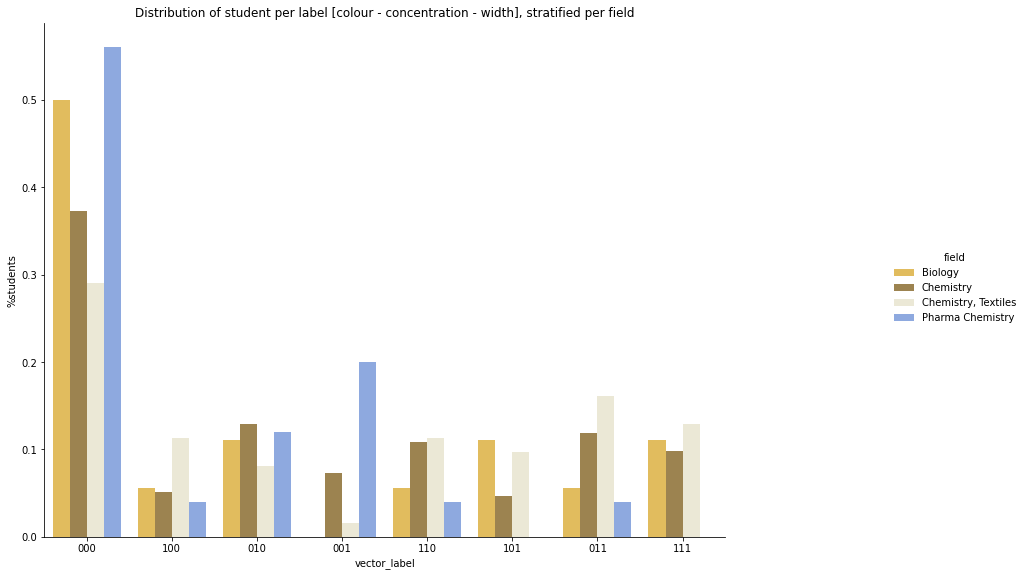

In [43]:
data = get_percentage(ranks, ['vector_label', 'field'], 'field')
s = sns.catplot(x='vector_label', y='height', hue='field', kind='bar', order=order, data=data, palette=palette)
s.fig.set_size_inches(15, 8)
plt.title('Distribution of student per label [colour - concentration - width], stratified per field')
plt.ylabel('%students')
plt.savefig('../../reports/LAK/figures/vector label distribution - field.svg', format='svg')
plt.show()

# N Concept EDA

In [36]:
ranks['nconcepts'] = ranks['vector_label'].apply(lambda x: sum([int(label) for label in x])).astype(str)

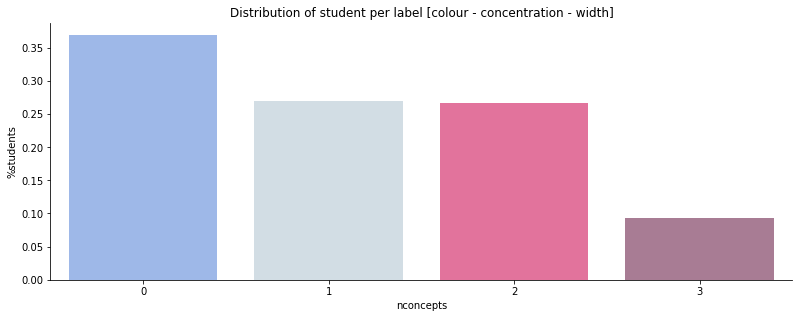

In [37]:
data = get_percentage(ranks, ['nconcepts', 'no_strat'], 'no_strat')
s = sns.catplot(x='nconcepts', y='height', kind='bar', data=data, palette=palette)
s.fig.set_size_inches(12, 4)
plt.title('Distribution of student per label [colour - concentration - width]')
plt.ylabel('%students')
plt.show()

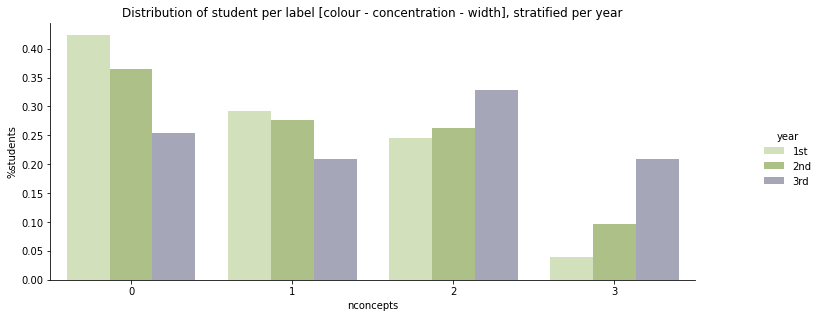

In [40]:
data = get_percentage(ranks, ['nconcepts', 'year'], 'year')
s = sns.catplot(x='nconcepts', y='height', hue='year', kind='bar', data=data, palette=palette)
s.fig.set_size_inches(12, 4)
plt.title('Distribution of student per label [colour - concentration - width], stratified per year')
plt.ylabel('%students')
plt.show()

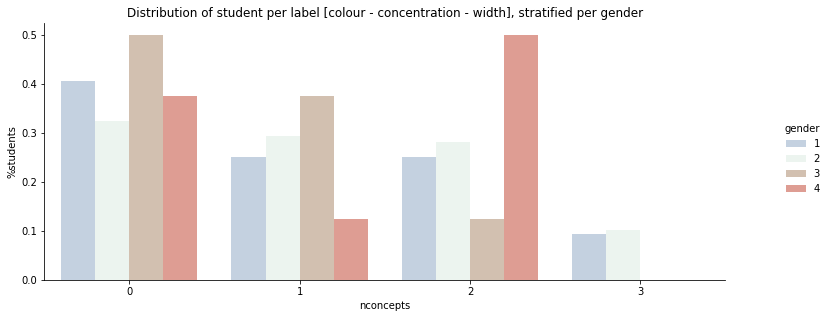

In [39]:
data = get_percentage(ranks, ['nconcepts', 'gender'], 'gender')
s = sns.catplot(x='nconcepts', y='height', hue='gender', kind='bar', data=data, palette=palette)
s.fig.set_size_inches(12, 4)
plt.title('Distribution of student per label [colour - concentration - width], stratified per gender')
plt.ylabel('%students')
plt.show()

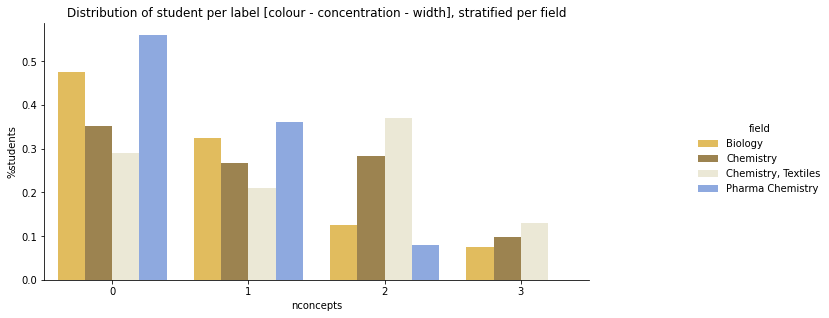

In [38]:
data = get_percentage(ranks, ['nconcepts', 'field'], 'field')
s = sns.catplot(x='nconcepts', y='height', hue='field', kind='bar', data=data, palette=palette)
s.fig.set_size_inches(12, 4)
plt.title('Distribution of student per label [colour - concentration - width], stratified per field')
plt.ylabel('%students')
plt.show()

In [2]:
a = {1: ["4"]}
b = {2: 4}

In [3]:
a.update(b)

In [4]:
a

{1: ['4'], 2: 4}

In [5]:
from collections import Counter

In [7]:
d = Counter()

In [8]:
d[0] += 0.3
d[1] += 0.4
d[7] += 0.02
d[1] -= 0.3
d[7] += 0.7

In [9]:
d

Counter({0: 0.3, 1: 0.10000000000000003, 7: 0.72})

In [5]:
for col in post_test.columns:
    print(col)

(0, 'consent')
(0, 'date')
(0, 'field')
(0, 'gender')
(0, 'invalid')
(0, 'lang')
(0, 'level')
(0, 'minor')
(0, 'progress')
(0, 'session')
(0, 'username')
(0, 'version')
(0, 'year')
(6, 'ranks')
(7, 'ans')
(7, 'rel')
(7, 'text')
(8, 'ans')
(8, 'rel')
(8, 'text')
(9, 'ans')
(9, 'rel')
(9, 'text')
(10, 'ans')
(10, 'rel')
(10, 'text')
(11, 'score')
(11, 'sliders')
(12, 'score')
(12, 'sliders')
(13, 'r_concentration')
(13, 'r_formula')
(13, 'r_wavelength')
(13, 'r_width')
(13, 'score')
(13, 'text')
(13, 'text_de')
(13, 'text_en')
(14, 'choices')
(14, 'n_diagram')
(14, 'n_formula')
(14, 'n_table')
(14, 'n_text')
(15, 'r')
(15, 'text')
(15, 'text_de')
(15, 'text_en')
(17, 'choices')
(18, 'a_0')
(18, 'a_1')
(18, 'a_2')
(18, 'c_0')
(18, 'c_1')
(18, 'c_2')
(18, 'choices')
(18, 'idk')
(18, 'score')
(19, 'choices')
(19, 's_difficult')
(19, 's_entertain')
(19, 't_bad')
(19, 't_good')
(19, 't_what')
(19, 'text')
('time', 'total')
('time', 'aggregate')
('time', 'lost')
('time', 'sim_aggregate')
('tim

In [7]:
post_test[15, 'text_de']

0      Wir haben diese Thematik bereits in der Berufs...
1      Wir hatten es in der Schule damit gerechnet je...
2                                                    NaN
3      Praktisch eher weniger, Photometrie nur mit Ka...
4                   Unsicherheiten aber kann es brauchen
                             ...                        
444                                                  NaN
445                                                  NaN
446                                                  NaN
447                                                  NaN
448                                                  NaN
Name: (15, text_de), Length: 449, dtype: object